In [31]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.keras.layers import Dense
from numpy.random import default_rng
from sklearn.model_selection import train_test_split

In [32]:
# Loading pipeline params.
DATA_PATH = Path('data')
FILENAME_STOP = 'stop_90_diff_quat.csv'
FILENAME_0 = '0_90_diff_quat.csv'
FILENAME_90 = '90_90_diff_quat.csv'
FILENAME_180 = '180_90_diff_quat.csv'
FILENAME_270 = '270_90_diff_quat.csv'

NUM_TIMESTEPS = 6
IGNORE_FRACTION = 0.1
TEST_FRACTION = 0.25

# Training params.
LEARNING_RATE = 1e-5
EPOCHS = 100
BATCH_SIZE = 512

In [33]:
def load_data(
    path_stop,
    path_0,
    path_90,
    path_180,
    path_270,
    num_timesteps,
    ignore_fraction,
    test_fraction,
):

    def read_and_prepare_data(
        path,
        class_,
        num_timesteps,
        ignore_fraction,
        test_fraction,
    ):

        def split_temporally(X, test_fraction):
            num_samples = X.shape[0]
            num_train = int(num_samples * (1.0 - test_fraction))
            X_train, X_test = X[:num_train], X[num_train:]
            return X_train, X_test

        def transform_into_sequences(X, num_timesteps):
            num_samples = X.shape[0]
            X_seq = []
            for k in range(num_samples - num_timesteps + 1):
                X_seq.append(X[k:(k + num_timesteps)])
            X_seq = np.array(X_seq)
            y_seq = class_ * np.ones((X_seq.shape[0], 1))
            return X_seq, y_seq

        X = pd.read_csv(path).values
        X = X[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]]

        # Ignore beginning and end.
        num_samples = X.shape[0]
        num_ignore = int(ignore_fraction * num_samples)
        X = X[num_ignore:-num_ignore]

        # Split X temporally.
        X_train, X_test = split_temporally(X, test_fraction)
        
        # Transform X into short sequences.
        X_train, y_train = transform_into_sequences(X_train, num_timesteps)
        X_test, y_test = transform_into_sequences(X_test, num_timesteps)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
        return X_train, y_train, X_test, y_test, X_val, y_val

    def shuffle_data(X, y):
        idx = np.arange(len(X))
        default_rng().shuffle(idx)
        X_shuffled = X[idx, :]
        y_shuffled = y[idx]
        return X_shuffled, y_shuffled

    X_train_stop, y_train_stop, X_test_stop, y_test_stop, X_val_stop, y_val_stop = \
        read_and_prepare_data(
            path_stop,
            0.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_0, y_train_0, X_test_0, y_test_0, X_val_0, y_val_0 = \
        read_and_prepare_data(
            path_0,
            1.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )

    X_train_90, y_train_90, X_test_90, y_test_90, X_val_90, y_val_90 = \
        read_and_prepare_data(
            path_90,
            2.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_180, y_train_180, X_test_180, y_test_180, X_val_180, y_val_180 = \
        read_and_prepare_data(
            path_180,
            3.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_270, y_train_270, X_test_270, y_test_270,X_val_270, y_val_270  = \
        read_and_prepare_data(
            path_270,
            4.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )

    X_train = np.concatenate((X_train_stop, X_train_0, X_train_90, X_train_180, X_train_270), axis=0)
    y_train = np.concatenate((y_train_stop, y_train_0, y_train_90, y_train_180, y_train_270), axis=0)
    X_test = np.concatenate((X_test_stop, X_test_0, X_test_90, X_test_180, X_test_270), axis=0)
    y_test = np.concatenate((y_test_stop, y_test_0, y_test_90, y_test_180, y_test_270), axis=0)
    X_val = np.concatenate((X_val_stop, X_val_0, X_val_90, X_val_180, X_val_270), axis=0)
    y_val = np.concatenate((y_val_stop, y_val_0, y_val_90, y_val_180, y_val_270), axis=0)

    
    
    X_train, y_train = shuffle_data(X_train, y_train)
    X_test, y_test = shuffle_data(X_test, y_test)
    X_val, y_val = shuffle_data(X_val, y_val)
    return X_train, X_test,X_val, y_train, y_test, y_val


path_stop = Path(DATA_PATH, FILENAME_STOP)
path_0 = Path(DATA_PATH, FILENAME_0)
path_90 = Path(DATA_PATH, FILENAME_90)
path_180 = Path(DATA_PATH, FILENAME_180)
path_270 = Path(DATA_PATH, FILENAME_270)

X_train, X_test, X_val, y_train, y_test , y_val= load_data(
    path_stop,
    path_0,
    path_90,
    path_180,
    path_270,
    NUM_TIMESTEPS,
    IGNORE_FRACTION,
    TEST_FRACTION,
)

In [34]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14375, 6, 14), (14375, 1), (2385, 6, 14), (2385, 1))

In [35]:
X_test[60].shape


(6, 14)

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

CNN = Sequential(name="Sequential_CNN")

CNN.add(Conv2D(256, kernel_size=(2, 2),
               strides=(4, 4), padding="same",
               activation="selu", input_shape=[6, 14, 1]))

CNN.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1),
                     padding="valid"))

# Add another pair of Conv2D and MaxPooling2D for more model depth,
# followed by the flatten and multiple dense layers

# CNN.add(Conv2D(64, kernel_size=(3, 3),
#                strides=(1, 1), padding="same",
#                activation="selu"))

# CNN.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1),
#                      padding="valid"))

CNN.add(Flatten())

CNN.add(Dense(64, activation='selu'))
CNN.add(Dense(32, activation='selu'))
CNN.add(Dense(5, activation='softmax'))

CNN.summary()

Model: "Sequential_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 2, 4, 256)         1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 3, 256)        0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 768)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                49216     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 5)                 165       
                                                    

In [37]:
from numpy import *
where_are_NaNsx = isnan(X_train)
X_train[where_are_NaNsx] = 0

where_are_NaNsy = isnan(y_train)
y_train[where_are_NaNsy] = 0

where_are_NaNsxt = isnan(X_test)
X_test[where_are_NaNsxt] = 0

where_are_NaNsyt = isnan(y_test)
y_test[where_are_NaNsyt] = 0

In [38]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

CNN.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)
history = CNN.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=1,
)

Epoch 1/100
57/57 [==============================] - 1s 11ms/step - loss: 0.7675 - accuracy: 0.7505 - val_loss: 0.5037 - val_accuracy: 0.8234
Epoch 2/100
57/57 [==============================] - 1s 10ms/step - loss: 0.4878 - accuracy: 0.8265 - val_loss: 0.4013 - val_accuracy: 0.8569
Epoch 3/100
57/57 [==============================] - 1s 9ms/step - loss: 0.4217 - accuracy: 0.8495 - val_loss: 0.3622 - val_accuracy: 0.8690
Epoch 4/100
57/57 [==============================] - 1s 9ms/step - loss: 0.3650 - accuracy: 0.8753 - val_loss: 0.2897 - val_accuracy: 0.9310
Epoch 5/100
57/57 [==============================] - 1s 9ms/step - loss: 0.3256 - accuracy: 0.8913 - val_loss: 0.2740 - val_accuracy: 0.9259
Epoch 6/100
57/57 [==============================] - 0s 9ms/step - loss: 0.3014 - accuracy: 0.9016 - val_loss: 0.2762 - val_accuracy: 0.9444
Epoch 7/100
57/57 [==============================] - 1s 9ms/step - loss: 0.2861 - accuracy: 0.9074 - val_loss: 0.3292 - val_accuracy: 0.9142
Epoch 8/100

Epoch 59/100
57/57 [==============================] - 0s 8ms/step - loss: 0.1083 - accuracy: 0.9668 - val_loss: 0.3014 - val_accuracy: 0.9293
Epoch 60/100
57/57 [==============================] - 0s 8ms/step - loss: 0.1089 - accuracy: 0.9654 - val_loss: 0.3871 - val_accuracy: 0.8703
Epoch 61/100
57/57 [==============================] - 0s 8ms/step - loss: 0.1264 - accuracy: 0.9585 - val_loss: 0.2824 - val_accuracy: 0.9368
Epoch 62/100
57/57 [==============================] - 1s 9ms/step - loss: 0.1031 - accuracy: 0.9686 - val_loss: 0.2894 - val_accuracy: 0.9285
Epoch 63/100
57/57 [==============================] - 0s 8ms/step - loss: 0.1023 - accuracy: 0.9688 - val_loss: 0.2400 - val_accuracy: 0.9456
Epoch 64/100
57/57 [==============================] - 0s 8ms/step - loss: 0.1051 - accuracy: 0.9670 - val_loss: 0.2392 - val_accuracy: 0.9159
Epoch 65/100
57/57 [==============================] - 0s 8ms/step - loss: 0.1066 - accuracy: 0.9656 - val_loss: 0.2531 - val_accuracy: 0.9297
Epoch 

In [39]:
# from functools import partial



# _, num_time, num_feat = X_train.shape

# activation = 'selu'

# DefaultConv1D = partial(
#     keras.layers.Conv1D,
#     kernel_size=1,
#     activation=activation,
#     padding="valid",
# )

# model = keras.models.Sequential([
#     DefaultConv1D(4 * num_feat, kernel_size=2, input_shape=[num_time, num_feat]),
#     keras.layers.BatchNormalization(),
#     DefaultConv1D(num_feat, kernel_size=2),
#     keras.layers.Flatten(),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(num_time * num_feat, activation=activation),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(num_feat, activation=activation),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(5, activation='softmax'),
# ])

# optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# model.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=optimizer,
#     metrics=['accuracy'],
# )

# history = model.fit(
#     X_train,
#     y_train,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     validation_data=(X_test, y_test),
#     verbose=1,
# )

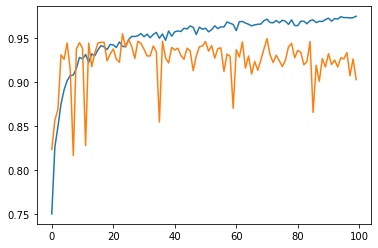

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

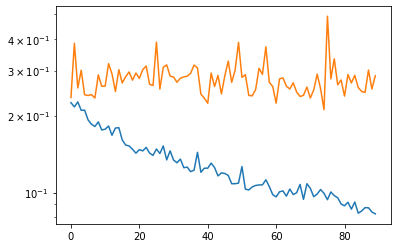

In [41]:
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.yscale('log')

In [42]:
y_pred = CNN.predict(X_test)

75/75 [==============================] - 0s 2ms/step


In [43]:
y_pred

array([[1.62034994e-05, 2.70756689e-04, 9.86508369e-01, 1.32046295e-02,
        2.26755614e-09],
       [4.89199907e-03, 9.26652908e-01, 6.84408322e-02, 1.04378897e-08,
        1.42468843e-05],
       [2.64905998e-03, 2.86104704e-08, 1.95435461e-18, 1.09287157e-07,
        9.97350812e-01],
       ...,
       [9.97730672e-01, 2.20130687e-03, 1.72852888e-09, 9.48632950e-10,
        6.80040903e-05],
       [6.52207388e-03, 9.90144571e-08, 5.72596464e-18, 2.42230726e-07,
        9.93477583e-01],
       [4.16578026e-03, 8.06478085e-04, 9.78733003e-01, 1.62947644e-02,
        2.53033328e-09]], dtype=float32)

In [44]:
y_pred= np.argmax(y_pred, axis=1)

In [45]:
y_pred

array([2, 1, 4, ..., 0, 4, 2])

In [46]:
y_pred[0]

2

In [47]:
df = pd.DataFrame({
    'y_test': y_test.ravel().astype(int).tolist(),
    'y_pred': y_pred.ravel().astype(int).tolist(),
})

In [48]:
pd.crosstab(df['y_test'], df['y_pred'])

y_pred,0,1,2,3,4
y_test,,,,,
0,380,5,0,57,35
1,47,327,103,0,0
2,0,0,470,7,0
3,0,0,0,477,0
4,0,0,0,0,477


In [49]:
# model.save('model.h5')

In [50]:
CNN.save('model_f_s_d_o_90_2.h5')